### Preparing the Data

In [94]:
import requests
import json

url = 'https://api.thevirustracker.com/free-api?countryTimeline=US'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [95]:
import pandas as pd
import numpy as np

data= pd.DataFrame(Data)
data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/01/20,2/02/20,2/03/20,2/04/20,2/05/20,2/06/20,2/07/20,2/08/20,2/09/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/01/20,...,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/01/20,7/02/20,7/03/20,7/04/20,7/05/20,7/06/20,7/07/20,7/08/20,7/09/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,stat
new_daily_cases,1,0,1,0,3,0,0,0,0,2,1,0,3,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,36,0,6,1,2,8,6,...,25510,19562,25697,27210,21553,17456,24182,24473,26427,32584,31783,25079,30928,35385,34631,40464,45330,42435,39677,37370,46552,50111,54437,55756,47718,38704,47183,69351,55000,65551,61544,66261,57794,55847,62874,74513,69629,74443,63402,ok
new_daily_deaths,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1082,867,913,734,382,361,764,809,671,727,584,304,402,806,745,648,2410,512,296,321,1197,684,681,655,348,217,337,1154,833,1000,745,779,436,369,795,916,966,875,884,ok
total_cases,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,...,1999313,2018875,2044572,2071782,2093335,2110791,2134973,2159446,2185873,2218457,2250240,2275319,2306247,2341632,2376263,2416727,2462057,2504492,2544169,2581539,2628091,2678202,2732639,2788395,2836113,2874817,2922000,2991351,3046351,3111902,3173446,3239707,3297501,3353348,3416222,3490735,3560364,3634807,3698209,ok
total_recoveries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,5,5,5,5,6,6,6,7,7,7,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,924148,924148,924148,924148,924148,924148,924148,924148,924148,924148,924148,924148,ok
total_deaths,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,112833,113700,114613,115347,115729,116090,116854,117663,118334,119061,119645,119949,120351,121157,121902,122550,124960,125472,125768,126089,127286,127970,128651,129306,129654,129871,130208,131362,132195,133195,133940,134719,135155,135524,136319,137235,138201,139076,139960,ok


In [99]:
data= pd.DataFrame(Data)
series = data.iloc[0].to_numpy()
series = series[:-1]
series = series.astype('float32')
mean= np.mean(series)
var= np.var(series)
series = ((series - mean)/var)*10000
series

array([-0.600217  , -0.6002461 , -0.600217  , -0.6002461 , -0.6001589 ,
       -0.6002461 , -0.6002461 , -0.6002461 , -0.6002461 , -0.60018796,
       -0.600217  , -0.6002461 , -0.6001589 , -0.6002461 , -0.6002461 ,
       -0.6002461 , -0.6002461 , -0.6002461 , -0.6002461 , -0.6002461 ,
       -0.600217  , -0.6002461 , -0.600217  , -0.6002461 , -0.6002461 ,
       -0.6002461 , -0.6002461 , -0.6002461 , -0.6002461 , -0.6002461 ,
       -0.60018796, -0.6002461 , -0.6002461 , -0.5992001 , -0.6002461 ,
       -0.6000717 , -0.600217  , -0.60018796, -0.6000136 , -0.6000717 ,
       -0.5995488 , -0.599665  , -0.5993454 , -0.5982705 , -0.5989387 ,
       -0.59617865, -0.5968759 , -0.5983576 , -0.5893221 , -0.590891  ,
       -0.5891478 , -0.5852547 , -0.584325  , -0.57781714, -0.567329  ,
       -0.5482702 , -0.56067586, -0.4290077 , -0.44269168, -0.41462648,
       -0.37401038, -0.29312685, -0.3128248 , -0.2505061 , -0.07560707,
       -0.08249263, -0.02438664, -0.03638553,  0.00757165,  0.16

In [100]:
time = data.columns.tolist()
time = time[:-1]


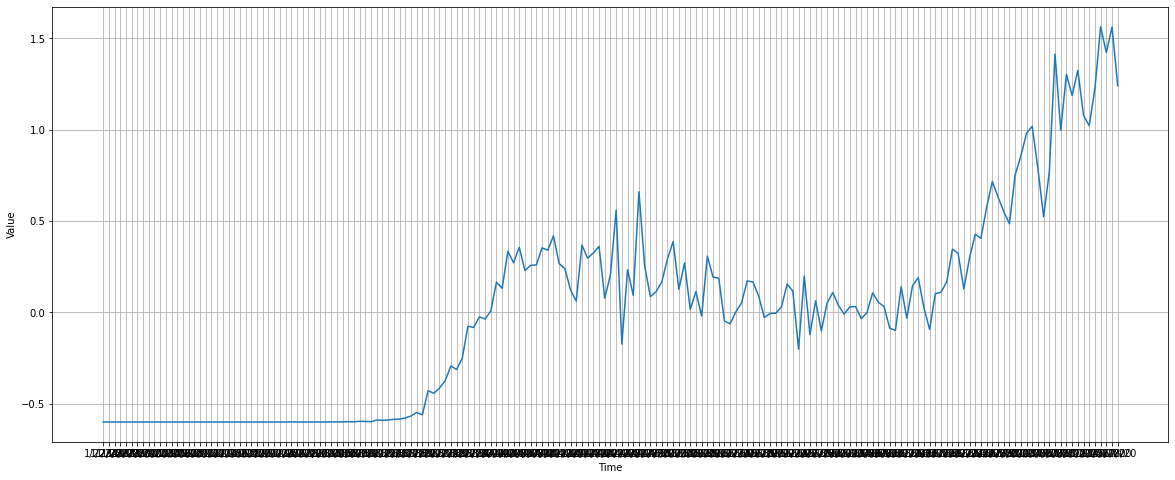

In [101]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(20, 8))
plot_series(time, series)

In [102]:
split_time = int(0.8 * series.shape[0])
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10
batch_size = 5
shuffle_buffer_size = 500

In [103]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [104]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### The model

In [139]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 64
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(next(iter(train_set.take(5))))
# print(x_train.shape)

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)


Epoch 1/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.0000e-08
Epoch 2/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.1220e-08
Epoch 3/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.2589e-08
Epoch 4/100
27/27 [==============================] - 0s 18ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.4125e-08
Epoch 5/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.5849e-08
Epoch 6/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.7783e-08
Epoch 7/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 1.9953e-08
Epoch 8/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 2.2387e-08
Epoch 9/100
27/27 [==============================] - 1s 19ms/step - loss: 0.3238 - mae: 0.3238 - lr: 2.5

(5.655877526068171e-09,
 0.0015757960743081156,
 0.1435179740190506,
 0.332348045706749)

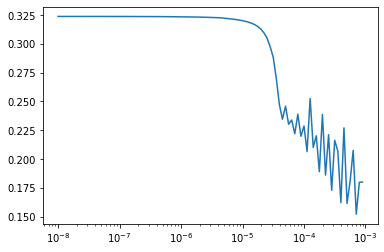

In [140]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

In [141]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

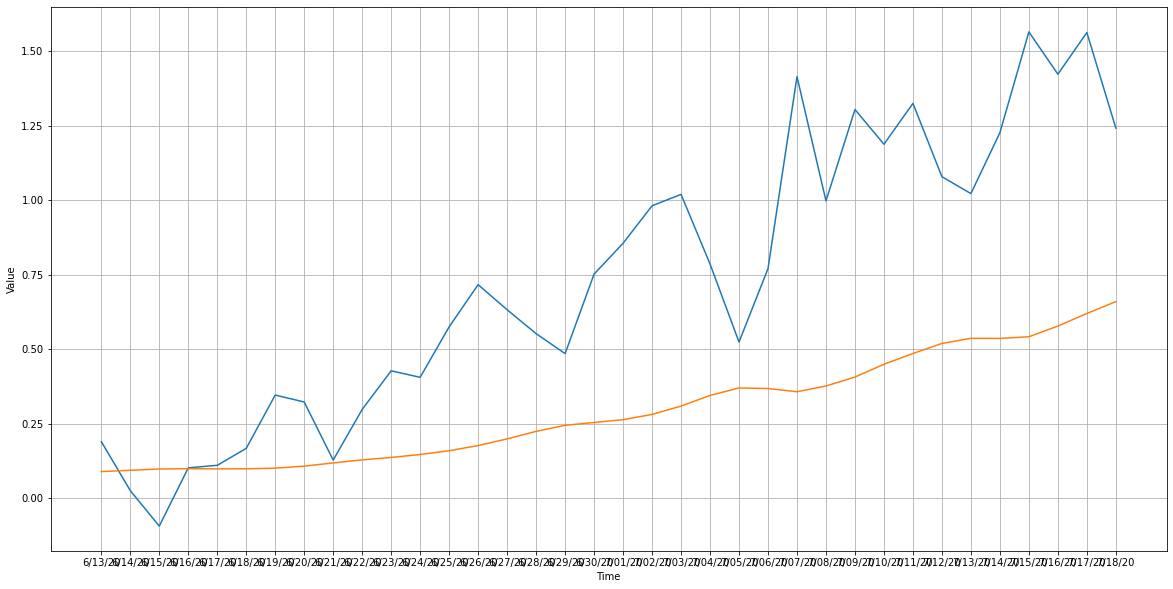

In [142]:
plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

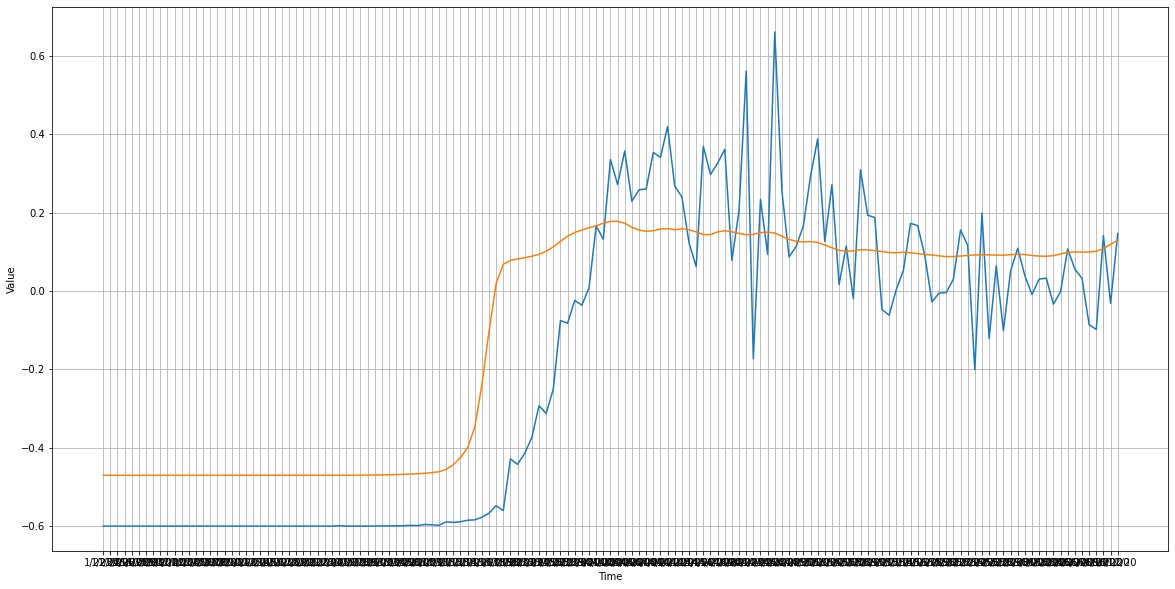

In [143]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)